# Plot modality
Choose the plot modality commenting/uncommenting the corresponding section.

## By the User Interface (UI)
Plot the data directly by the User Interface: the plotting opens a new window and the kernel is busy (it is not possible continue to use the UI in the meanwhile) until it is closed.

In [1]:
#%matplotlib qt
#mod_flag = 0

## By the external cell 
Plot the data into the section 2: the plotting is in-line and it is possible continue to use the User Interface in the meanwhile.

In [2]:
%matplotlib inline
%matplotlib notebook
mod_flag = 1 

# User Interface
Run the UI to control the robot and plot data.

## Headers and Global variables

In [3]:
# Robotics control in a simulated environment
# Robotics Engineering
# 
# @file rt2_rt2_jupyter_ui.ipynb
# @author Simone Contorno (@simone-contorno)
# @copyright Copyright (c) 2022

import threading

# Jupyter headers
import jupyros as jr
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, VBox, HBox
from IPython.display import display, clear_output

# ROS headers
import rospy
import actionlib
from geometry_msgs.msg import Twist
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal, MoveBaseActionGoal

# Visualiser headers
import matplotlib.pyplot as plt
import numpy as np
import tf
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from tf.transformations import quaternion_matrix
from matplotlib.animation import FuncAnimation

# Publishers
pub_vel = rospy.Publisher("/cmd_vel", Twist, queue_size = 1000)
pub_goal = rospy.Publisher('/move_base/goal', MoveBaseActionGoal, queue_size = 1000)

# Widgets output
send_out = widgets.Output()
canc_out = widgets.Output()
output = widgets.Output()

# Global variables (coordinates and velocities)
x = 0.0
y = 0.0
lin_vel = 1.0
ang_vel = 0.0
rate = 0.001 # Rate of 1 ms to update date in the plot

# Flags 
hist_flag = 0
goal_flag = 0
assist_flag = 0

# Ros parameter and object
rospy.set_param('/goal_flag', goal_flag)
robot_vel = Twist() 

# Button attributes
button_layout = Layout(width = '300px')
button_style = dict(
    font_style = 'italic',
    font_weight = 'bold',
    font_variant = "small-caps",
    text_color = 'red',
    text_decoration = 'none'
)

## Class Visualiser
Class used to plot the robot position, the laser values and the reached/non-reached goal, dinamically.

In [4]:
## Class to visualize data
class Visualiser:    
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.fig.canvas.manager.set_window_title('Data plotting')
        self.pl, = plt.plot([], [], 'ro')
        self.pp, = plt.plot([], [], 'ro')
        self.x_pos, self.y_pos = [] , []
        self.x_scan, self.y_scan = [] , []
    
    def pp_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.pp
    
    def pl_init(self): 
        self.ax.set_xlim(-10, 730)
        self.ax.set_ylim(0, 15)
        return self.pl
    
    ## Update data
    # Robot position
    def update_odom(self, frame):
        self.pp.set_data(self.x_pos, self.y_pos)
        return self.pp
    
    # Laser scanner
    def update_scan(self, frame):
        self.pl.set_data(self.x_scan, self.y_scan)
        return self.pl
    
    ## Callbacks
    # Robot position
    def odom_callback(self, msg):
        if hist_flag == 0:
            self.x_pos.clear();
            self.y_pos.clear();
        self.y_pos.append(msg.pose.pose.position.y)
        self.x_pos.append(msg.pose.pose.position.x)
    
    # Laser scanner
    def scan_callback(self, msg):
        self.x_scan.clear();
        self.y_scan.clear();
        for i in range(len(msg.ranges)):
            self.y_scan.append(msg.ranges[i])
            self.x_scan.append(len(msg.ranges)-i)

## Functions

### General functions
Functions used by the different interface modalities (main one, manual driving, plotting and new goal) of the UI.

In [5]:
## Clear the button outputs
def clear_out(arg):
    output.clear_output()
    send_out.clear_output()
    canc_out.clear_output()

In [6]:
## Terminate the program
def terminate(arg):
    rospy.set_param('/goal_flag', 0)
    clear_output() # Clear the cell output
    print("\033[1;30m" + "Bye.")

In [7]:
## Go back to the interface
def back(arg):
    clear_output() # Clear the cell output
    interface()

In [8]:
## Enable driving assistance for the Menu interface
def enable_driving_assistance(arg):
    global assist_flag
    assist_flag = 1
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/drive_flag', 1)
    clear_output() # Clear the cell output
    interface()

In [9]:
## Disable driving assistance for the Menu interface
def disable_driving_assistance(arg):
    global assist_flag
    assist_flag = 0
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/drive_flag', 0)
    clear_output() # Clear the cell output
    interface()

### Manual driving functions
Functions used by the manual driving interface.

In [10]:
## Enable driving assistance for the Manual driving interface
def enable_driving_assistance_2(arg):
    global assist_flag
    assist_flag = 1
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/drive_flag', 1)
    clear_output() # Clear the cell output
    manual_driving(_)

In [11]:
## Disable driving assistance for the Manual driving interface
def disable_driving_assistance_2(arg):
    global assist_flag
    assist_flag = 0
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/drive_flag', 0)
    clear_output() # Clear the cell output
    manual_driving(_)

In [12]:
## Go on 
def go_on(arg):
    global lin_vel
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/key_flag', 0)
    
    robot_vel.linear.x = lin_vel.value
    robot_vel.angular.z = 0
    pub_vel.publish(robot_vel)
    
    with output:
        output.clear_output()
        if lin_vel.value == 0.0:
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "The linear velocity is set to 0.0: " +
                  "the robot is not moving.")
        else: 
            print("\033[1;34m" + "INFO: " +
                  "\033[0;30m" + "The robot is going on.")

In [13]:
## Go back
def go_back(arg):
    global lin_vel
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/key_flag', 3)
    
    robot_vel.linear.x = -lin_vel.value
    robot_vel.angular.z = 0
    pub_vel.publish(robot_vel)
    
    with output:
        output.clear_output()
        if lin_vel.value == 0.0:
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "The linear velocity is set to 0.0: " +
                  "the robot is not moving.")
        else: 
            print("\033[1;34m" + "INFO: " +
                  "\033[0;30m" + "The robot is going back.")

In [14]:
## Curve left
def curve_left(arg):
    global lin_vel
    global ang_vel
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/key_flag', 1)
    
    robot_vel.linear.x = lin_vel.value
    robot_vel.angular.z = ang_vel.value
    pub_vel.publish(robot_vel)
    
    with output:
        output.clear_output()
        if lin_vel.value == 0.0:
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "The linear velocity is set to 0.0: " + 
                  "the robot is going on.")
        elif ang_vel.value == 0.0:
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "The angular velocity is set to 0.0 " + 
                  "the robot is going on.")
        elif ang_vel.value == 0.0 and lin_vel.value == 0:
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "The angular and the linear velocities are set to 0.0: " + 
                  "the robot is not moving.")
        else: 
            print("\033[1;34m" + "INFO: " +
                  "\033[0;30m" + "The robot is curving left.")

In [15]:
## Curve right
def curve_right(arg):
    global lin_vel
    global ang_vel
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/key_flag', 2)
    
    robot_vel.linear.x = lin_vel.value
    robot_vel.angular.z = -ang_vel.value
    pub_vel.publish(robot_vel)
    
    with output:
        output.clear_output()
        if lin_vel.value == 0.0:
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "The linear velocity is set to 0.0: " + 
                  "the robot is going on.")
        elif ang_vel.value == 0.0:
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "The angular velocity is set to 0.0 " + 
                  "the robot is going on.")
        elif ang_vel.value == 0.0 and lin_vel.value == 0:
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "The angular and the linear velocities are set to 0.0: " + 
                  "the robot is not moving.")
        else: 
            print("\033[1;34m" + "INFO: " +
                  "\033[0;30m" + "The robot is curving right.")

In [16]:
## Turn left
def turn_left(arg):
    global ang_vel
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/key_flag', 3)
    
    robot_vel.linear.x = 0.0
    robot_vel.angular.z = ang_vel.value
    pub_vel.publish(robot_vel)
    
    with output:
        output.clear_output()
        if ang_vel.value == 0.0:
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "The angular velocity is set to 0.0: " + 
                  "the robot is not moving.")
        else: 
            print("\033[1;34m" + "INFO: " +
                  "\033[0;30m" + "The robot is turning left.")

In [17]:
## Turn right
def turn_right(arg):
    global ang_vel
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/key_flag', 3)
    
    robot_vel.linear.x = 0.0
    robot_vel.angular.z = -ang_vel.value
    pub_vel.publish(robot_vel)
    
    with output:
        output.clear_output()
        if ang_vel.value == 0.0:
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "The angular velocity is set to 0.0: " + 
                  "the robot is not moving.")
        else: 
            print("\033[1;34m" + "INFO: " +
                  "\033[0;30m" + "The robot is turning right.")

In [18]:
## Stop
def stop(arg):
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/key_flag', 3)
    
    robot_vel.linear.x = 0.0
    robot_vel.angular.z = 0.0
    pub_vel.publish(robot_vel)
    
    with output:
        output.clear_output()
        print("\033[1;34m" + "INFO: " +
                  "\033[0;30m" + "The robot is not moving.")   

In [19]:
## Quit manual driving 
def quit(arg):
    rospy.set_param('/print_flag', 0)
    rospy.set_param('/key_flag', 3)
    
    robot_vel.linear.x = 0.0
    robot_vel.angular.z = 0.0
    pub_vel.publish(robot_vel)
        
    clear_output() # Clear the cell output
    interface()

### Manual driving interface
Control the robot manually, setting the linear and the angular velocities, and using the buttons to choose the direction to run across.

In [20]:
## Manual driving 
def manual_driving(arg):
    clear_output() # Clear the cell output
    print("\033[1;31m" + "\nManual driving\n")
    print("\033[1;33m" + "WARNING: " + 
          "\033[0;30m" + "A linear velocity greater than 2.0, OR an Angular velocity " +
          "greater than 10.0, could crash the simulation with RViz.")
    
    global assist_flag 
    global lin_vel
    global ang_vel
    
    rospy.set_param('/print_flag', 0)
    goal_flag = rospy.get_param("/goal_flag")
    if goal_flag == 1:
        rospy.set_param('/goal_flag', 0)
        goal_flag = 0
    
    # Convert velocities type into float
    if isinstance(lin_vel, widgets.widgets.widget_float.FloatSlider):
        lin_vel = lin_vel.value
    if isinstance(ang_vel, widgets.widgets.widget_float.FloatSlider):
        ang_vel = ang_vel.value
    
    # Set linear and angular velocity
    lin_vel = widgets.FloatSlider( # Robot linear velocity
        value = lin_vel,
        min = 0.0,
        max = 10.0,
        step = 0.1,
        description = 'Linear velocity',
        disabled = False,
        continuous_update = False,
        orientation = 'horizontal',
        readout = True,
        readout_format='.1f',
    ) 
    ang_vel = widgets.FloatSlider( # Robot angular velocity
        value = ang_vel,
        min = 0.0,
        max = 10.0,
        step = 0.1,
        description = 'Angular velocity',
        disabled = False,
        continuous_update = False,
        orientation = 'horizontal',
        readout = True,
        readout_format='.1f',
    )
    
    # Buttons
    goon_b = widgets.Button(description = 'Go on', layout = button_layout, style = button_style)
    goon_b.style.button_color = 'lightgreen'
    
    goback_b = widgets.Button(description = 'Go back', layout = button_layout, style = button_style)
    goback_b.style.button_color = 'lightgreen'
    
    cleft_b = widgets.Button(description = 'Curve left', layout = button_layout, style = button_style)
    cleft_b.style.button_color = 'lightgreen'
    
    cright_b = widgets.Button(description = 'Curve right', layout = button_layout, style = button_style)
    cright_b.style.button_color = 'lightgreen'
    
    tleft_b = widgets.Button(description = 'Turn left', layout = button_layout, style = button_style)
    tleft_b.style.button_color = 'lightgreen'
    
    tright_b = widgets.Button(description = 'Turn right', layout = button_layout, style = button_style)
    tright_b.style.button_color = 'lightgreen'
    
    stop_b = widgets.Button(description = 'Stop', layout = button_layout, style = button_style)
    stop_b.style.button_color = 'yellow'
    
    with_assist_b = widgets.Button(description = 'Enable driving assistance', layout = button_layout, style = button_style)
    with_assist_b.style.button_color = 'lightgreen'
    
    without_assist_b = widgets.Button(description = 'Disable driving assistance', layout = button_layout, style = button_style)
    without_assist_b.style.button_color = 'orange'
    
    quit_b = widgets.Button(description = 'Quit', layout = button_layout, style = button_style)
    quit_b.style.button_color = 'red'
    
    # Buttons' function
    goon_b.on_click(go_on)
    goback_b.on_click(go_back)
    cleft_b.on_click(curve_left)
    cright_b.on_click(curve_right)
    tleft_b.on_click(turn_left)
    tright_b.on_click(turn_right)
    stop_b.on_click(stop)
    with_assist_b.on_click(enable_driving_assistance_2)
    without_assist_b.on_click(disable_driving_assistance_2)
    quit_b.on_click(back)
    
    # Display the buttons as a box
    if assist_flag == 0:
        display(lin_vel, ang_vel, 
            widgets.HBox((cleft_b, goon_b, cright_b)), 
            widgets.HBox((tleft_b, goback_b, tright_b,)),
            widgets.HBox((stop_b, with_assist_b, quit_b)), 
            output)
    elif assist_flag == 1:
        display(lin_vel, ang_vel, 
            widgets.HBox((cleft_b, goon_b, cright_b)), 
            widgets.HBox((tleft_b, goback_b, tright_b,)),
            widgets.HBox((stop_b, without_assist_b, quit_b)), 
            output)

### Goal management functions
Function used by the goal management interface. 

In [21]:
## Cancel the current goal
def cancel_goal(arg):
    goal_flag = rospy.get_param("/goal_flag")
    if goal_flag == 1:
        rospy.set_param('/goal_flag', 0)
        goal_flag = 0
        
        with canc_out:    
            canc_out.clear_output()
            print("\033[1;34m" + "INFO: " + 
                  "\033[0;30m" + "Goal cancelled.")
    else: 
        with canc_out:    
            canc_out.clear_output()
            print("\033[1;33m" + "WARNING: " + 
                  "\033[0;30m" + "There is no goal set.")

In [22]:
## Send the new coordinates
def send_coordinates(arg):
    goal_pos = MoveBaseActionGoal()    
    goal_pos.goal.target_pose.header.frame_id = "map"
    goal_pos.goal.target_pose.pose.orientation.w = 1;
    goal_pos.goal.target_pose.pose.position.x = x.value
    goal_pos.goal.target_pose.pose.position.y = y.value

    # Publish
    pub_goal.publish(goal_pos)
    rospy.set_param('/goal_flag', 1)
    
    with send_out:    
        send_out.clear_output()
        print("\033[1;34m" + "INFO: " + 
              "\033[0;30m" + "Goal sent.")

### Goal management interface
Insert the new coordinates to reach automatically with the robot.

In [23]:
## Set new coordinated
def set_coordinates(arg):
    clear_output() # Clear the cell output
    print("\033[1;31m" + "\nAutonomous driving\n")
    print("\033[1;30m" + "Set the coordinates to reach:")
    
    send_b = widgets.Button(description = 'Send', layout = button_layout, style = button_style) 
    send_b.style.button_color = 'lightgreen'
    back_b = widgets.Button(description = 'Back', layout = button_layout, style = button_style)
    back_b.style.button_color = 'red'
    
    global x
    global y 
    
    x = widgets.BoundedFloatText(
    value = 0.0,
    min = -100,
    step = 0.1,
    description = 'x :',
    disabled = False
    )
    y = widgets.BoundedFloatText(
    value = 0.0,
    min = -100,
    step = 0.1,
    description = 'y :',
    disabled = False
    )
    
    back_b.on_click(back)
    send_b.on_click(send_coordinates)
    
    display(x, y, send_b, back_b, send_out)

### Plot functions
Functions used by the plot interface.

In [24]:
## Plot the number of reached/non-reached targets
def plot_target(arg):
    reached_goal = rospy.get_param("/reached_goal")
    non_reached_goal = rospy.get_param("/non_reached_goal")
    targets = ["Reached", "Non-reached"]
    number = [reached_goal, non_reached_goal]
    
    fig = plt.figure()
    fig.canvas.manager.set_window_title('Data plotting')
    plt.bar(targets, number, color ='blue', width = 0.5)
    plt.title("Targets info")
    plt.xlabel("Targets")
    plt.ylabel("Number")
    plt.show(block = False)
    
    while plt.fignum_exists(1):
        plt.pause(rate) 
        
        # Update the histogram
        new_reached_goal = rospy.get_param("/reached_goal")
        new_non_reached_goal = rospy.get_param("/non_reached_goal")
        if (new_reached_goal != reached_goal) or (new_non_reached_goal != non_reached_goal):
            reached_goal = new_reached_goal
            non_reached_goal = new_non_reached_goal
            number = [reached_goal, non_reached_goal]
            plt.bar(targets, number, color ='blue', width = 0.5)

In [25]:
## Plot laser scanner data
def plot_laserscan(arg):
    vis = Visualiser() 
    ani = FuncAnimation(vis.fig, 
                        vis.update_scan, 
                        init_func = vis.pl_init)
    plt.title("Laser scanner")
    plt.ylabel("Distance")
    sub = rospy.Subscriber('/scan', LaserScan, vis.scan_callback)
    plt.show(block = False)
    
    while plt.fignum_exists(1):
        plt.pause(rate)

In [26]:
## Plot robot position data
def plot_position(arg):
    vis = Visualiser() 
    ani = FuncAnimation(vis.fig, 
                        vis.update_odom, 
                        init_func = vis.pp_init)
    plt.title("Robot position")
    plt.xlabel("x")
    plt.ylabel("y")
    sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
    plt.show(block = False)
    
    while plt.fignum_exists(1):
        plt.pause(rate)

In [27]:
## Plot robot position and laser scanner data
def plot_pos_and_scan(arg):
    vis1 = Visualiser() 
    ani1 = FuncAnimation(vis1.fig, 
                        vis1.update_odom, 
                        init_func = vis1.pp_init)
    plt.title("Robot position")
    plt.xlabel("x")
    plt.ylabel("y")
    sub = rospy.Subscriber('/odom', Odometry, vis1.odom_callback)
    plt.show(block = False)
    
    vis2 = Visualiser() 
    ani2 = FuncAnimation(vis2.fig, 
                        vis2.update_scan, 
                        init_func = vis2.pl_init)
    plt.title("Laser scanner")
    plt.ylabel("Distance")
    sub = rospy.Subscriber('/scan', LaserScan, vis2.scan_callback)
    plt.show(block = False)

    while plt.fignum_exists(1) or plt.fignum_exists(2):
        plt.pause(rate)

In [28]:
## Enable position history
def enable_pos_hist(arg):
    global hist_flag
    hist_flag = 1
    data_visualization(0)

In [29]:
## Disable position history
def disable_pos_hist(arg):
    global hist_flag
    hist_flag = 0
    data_visualization(0)

### Plot interface
Plot the the robot position, the laser values and the reached/non-reached goal, dinamically.

In [30]:
## Visualize data about robot position
def data_visualization(arg):  
    global hist_flag
    clear_output() # Clear the cell output
    
    # Choose the data to plot
    print("\033[1;31m" + "\nData plotting\n")
    print("\033[1;30m" + "Choose the data that you want to plot:")
    
    ## Buttons
    
    # Position button
    pos_b = widgets.Button(description = 'Plot position data', layout = button_layout, style = button_style)
    pos_b.style.button_color = 'lightgreen'
    pos_b.on_click(plot_position) # function
    
    # Laser button
    scan_b = widgets.Button(description = 'Plot laser scanner data', layout = button_layout, style = button_style)
    scan_b.style.button_color = 'lightgreen'
    scan_b.on_click(plot_laserscan) # function
    
    # Position and laser button
    pos_scan_b = widgets.Button(description = 'Plot position and laser scanner data', layout = button_layout, style = button_style)
    pos_scan_b.style.button_color = 'lightgreen'
    pos_scan_b.on_click(plot_pos_and_scan) # function
    
    # Number of reached/non-reached targets button
    target_b = widgets.Button(description = 'Plot targets info', layout = button_layout, style = button_style)
    target_b.style.button_color = 'lightgreen'
    target_b.on_click(plot_target) # function
    
    # Enable history button
    with_hist_b = widgets.Button(description = 'Enable position history', layout = button_layout, style = button_style)
    with_hist_b.style.button_color = 'lightgreen'
    with_hist_b.on_click(enable_pos_hist) # function
    
    # Disable history button
    without_hist_b = widgets.Button(description = 'Disable position history', layout = button_layout, style = button_style)
    without_hist_b.style.button_color = 'orange'
    without_hist_b.on_click(disable_pos_hist) # function
    
    # Back button
    back_b = widgets.Button(description = 'Back', layout = button_layout, style = button_style)
    back_b.style.button_color = 'red'
    back_b.on_click(back) # function 
    
    # Display buttons
    if hist_flag == 0:
        display(pos_b, scan_b, target_b, pos_scan_b, with_hist_b, back_b)    
    elif hist_flag == 1:
        display(pos_b, scan_b, target_b, pos_scan_b, without_hist_b, back_b)   

## User Interface (UI)
Main UI: terminate the program, plot data, insert new goal, cancel the current goal, pass to the manual driving and enable/disable the driving assistance.

In [31]:
## Show the UI
def interface():
    global assist_flag
    global mod_flag 
    
    # Choose the action to perform
    print("\033[1;31m" + "\nWelcome to the User Interface!\n")
    print("\033[1;30m" + "Here you can choose between two different modalities to control your robot:\n" 
          "- automatic goal reaching, or\n"
          "- manual driving (with or without the driving assistance!)\n"
          "Choose an action:")
    
    ## Buttons
    
    # Exit button
    exit_b = widgets.Button(description = 'Exit', layout = button_layout, style = button_style)
    exit_b.style.button_color = 'red'
    exit_b.on_click(terminate) # function
    
    # Plot data button
    plot_b = widgets.Button(description = 'Plot data', layout = button_layout, style = button_style)
    plot_b.style.button_color = 'lightgreen'
    plot_b.on_click(data_visualization) # function
    
    # Insert new goal button
    goal_b = widgets.Button(description = 'Insert new coordinates to reach', layout = button_layout, style = button_style)
    goal_b.style.button_color = 'lightgreen'
    goal_b.on_click(set_coordinates) # function
    
    # Cancel current goal button
    canc_b = widgets.Button(description = 'Cancel the current goal', layout = button_layout, style = button_style)
    canc_b.style.button_color = 'lightgreen'
    canc_b.on_click(cancel_goal) # function
    
    # Manual driving button
    drive_b = widgets.Button(description = 'Manual driving', layout = button_layout, style = button_style)
    drive_b.style.button_color = 'lightgreen'
    drive_b.on_click(manual_driving) # function
    
    # Enable driving assistance button
    with_assist_b = widgets.Button(description = 'Enable driving assistance', layout = button_layout, style = button_style)
    with_assist_b.style.button_color = 'lightgreen'
    with_assist_b.on_click(enable_driving_assistance) # function
    
    # Disable driving assistance button
    without_assist_b = widgets.Button(description = 'Disable driving assistance', layout = button_layout, style = button_style)
    without_assist_b.style.button_color = 'orange'
    without_assist_b.on_click(disable_driving_assistance) # function
    
    # Clear buttons' output button
    clear_b = widgets.Button(description = 'Clear button outputs', layout = button_layout, style = button_style)
    clear_b.style.button_color = 'yellow'
    clear_b.on_click(clear_out) # function
    
    # Display buttons
    
    if mod_flag == 0:
        if assist_flag == 0:
            display(exit_b, plot_b, goal_b, canc_b, canc_out, drive_b, with_assist_b, clear_b)   
        elif assist_flag == 1:
            display(exit_b, plot_b, goal_b, canc_b, canc_out, drive_b, without_assist_b, clear_b)
    elif mod_flag == 1:
        if assist_flag == 0:
            display(exit_b, goal_b, canc_b, canc_out, drive_b, with_assist_b, clear_b)   
        elif assist_flag == 1:
            display(exit_b, goal_b, canc_b, canc_out, drive_b, without_assist_b, clear_b)

## Main
Main function: initialize the node and run the UI. <br>
In order to plot the data through the UI: <br>
1) Uncomment the section 1.1 <br>
2) Comment the section 1.2

In [32]:
## main function to run the user interface
def main():
    rospy.init_node("rt2_robot_jupyter_ui")    
    interface()
    
if __name__ == '__main__':
    main()


Welcome to the User Interface!

Here you can choose between two different modalities to control your robot:
- automatic goal reaching, or
- manual driving (with or without the driving assistance!)
Choose an action:


Button(description='Exit', layout=Layout(width='300px'), style=ButtonStyle(button_color='red', font_weight='bo…

Button(description='Insert new coordinates to reach', layout=Layout(width='300px'), style=ButtonStyle(button_c…

Button(description='Cancel the current goal', layout=Layout(width='300px'), style=ButtonStyle(button_color='li…

Output()

Button(description='Manual driving', layout=Layout(width='300px'), style=ButtonStyle(button_color='lightgreen'…

Button(description='Enable driving assistance', layout=Layout(width='300px'), style=ButtonStyle(button_color='…

Button(description='Clear button outputs', layout=Layout(width='300px'), style=ButtonStyle(button_color='yello…

# Plot data (external cell) 
Plot the data into this external cell: <br>
1) Comment the section 1.1 <br>
2) Uncomment the section 1.2

## Robot position history
Comment/Uncomment this cell to enable/disable the robot position history during its plot.

In [33]:
hist_flag = 1 # uncomment this line to keep track of the robot movements

## Plotting code

In [34]:
# Update targets plot
def update_target(arg):
    reached_goal = rospy.get_param("/reached_goal")
    non_reached_goal = rospy.get_param("/non_reached_goal")
    targets = ["Reached", "Non-reached"]
    number = [reached_goal, non_reached_goal]
    
    plt.bar(targets, number, color ='blue', width = 0.5)

<IPython.core.display.Javascript object>


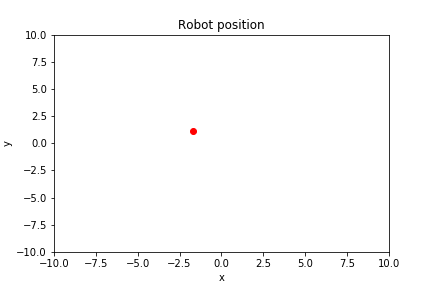

<IPython.core.display.Javascript object>


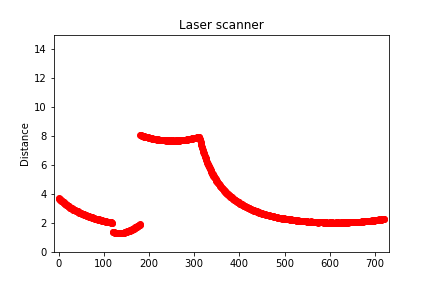

<IPython.core.display.Javascript object>


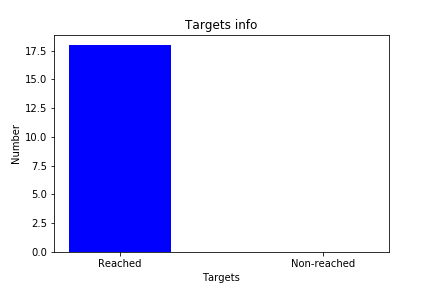

Button(description='Update targets plot', layout=Layout(width='300px'), style=ButtonStyle(button_color='lightg…

In [35]:
# Plot the robot data
if mod_flag == 1: 
    ## Plot robot position data

    vis1 = Visualiser() 
    ani1 = FuncAnimation(vis1.fig, 
                        vis1.update_odom, 
                        init_func = vis1.pp_init)
    plt.title("Robot position")
    plt.xlabel("x")
    plt.ylabel("y")
    sub = rospy.Subscriber('/odom', Odometry, vis1.odom_callback)
    plt.show(block = False)

    ## Plot laser scanner data
    vis2 = Visualiser() 
    ani2 = FuncAnimation(vis2.fig, 
                        vis2.update_scan, 
                        init_func = vis2.pl_init)
    plt.title("Laser scanner")
    plt.ylabel("Distance")
    sub = rospy.Subscriber('/scan', LaserScan, vis2.scan_callback)
    plt.show(block = False)

    ## Plot the number of reached/non-reached targets
    reached_goal = rospy.get_param("/reached_goal")
    non_reached_goal = rospy.get_param("/non_reached_goal")
    targets = ["Reached", "Non-reached"]
    number = [reached_goal, non_reached_goal]

    fig = plt.figure()
    fig.canvas.manager.set_window_title('Data plotting')
    plt.bar(targets, number, color ='blue', width = 0.5)
    plt.title("Targets info")
    plt.xlabel("Targets")
    plt.ylabel("Number")
    plt.show(block = False)
    
    target_b = widgets.Button(description = 'Update targets plot', layout = button_layout, style = button_style)
    target_b.style.button_color = 'lightgreen'
    target_b.on_click(update_target) # function
    
    display(target_b)

# 3D map
Show the 3D map in which the robot moves.

In [36]:
## Visualize the 3D map, the robot and the laser scanner

# Jupyter headers
import os
from jupyros import ros3d

view = ros3d.Viewer() # ROS 3D object
rc = ros3d.ROSConnection(url = "ws://localhost:9090") # Websocket (9090:rosbridge)
tf_client = ros3d.TFClient(ros = rc, fixed_frame = 'map') # Client connection 

# Visualize the map, the laser and the path to follow
map_view = ros3d.OccupancyGrid(topic = "/map", ros = rc, tf_client = tf_client) 
laser_view = ros3d.LaserScan(topic = "/scan", ros = rc, tf_client = tf_client) 
path = ros3d.Path(topic = "/move_base/NavfnROS/plan", ros = rc, tf_client = tf_client)

urdf = ros3d.URDFModel(ros = rc, tf_client = tf_client,
    path = os.environ.get('JUPYROS_ASSETS_URL', 'http://localhost:3000'))

g = ros3d.GridModel() # Grid object

# Show the model
view.objects = [g, laser_view, map_view, path, urdf]
view

Viewer(objects=[GridModel(), LaserScan(ros=ROSConnection(url='ws://localhost:9090'), tf_client=TFClient(fixed_…